# ST446 Final Project
---

### Building Scalable Machine Learning Pipelines for Click Predictions
**By: Traci Lim**

## Abstract

Machine learning is continuously at the forefront of any data-driven industry, it is all about providing consumers and businesses valuable insight. Traditional machine learning approaches, which were developed based on the assumption that data fits entirely into memory, no longer remain relevant in the proliferation of big data. Scalability, to put it in a crude sense, is all about being able to take one piece of code, and then throw any number of computers at it to make it fast. Scalable machine learning is at the forefront now, where it brought a wave of competitive cloud computing services, state-of-the-art scalable algorithms, and cluster computing open-sourced frameworks. This report will attempt to predict click-through rate using a parallelized binary classifier, while utilizing Apache Spark's machine learning library MLlib on Azure HDinsight clusters. We will include short expositions on algorithms used, as well as fairly detailed commentaries on the machine learning process, aimed for the typical machine learning wannabe. Lastly, we share our experience and learning on the distributed performance of algorithms in MLlib.



---
## Table of Contents
1. [Data and Objectives](#data-and-objectives)
2. [Experimental Setup](#experimental-setup)
3. [Methodology](#methodolgy)
4. [Machine Learning Process](#machine-learning-process)
    1. [Load data](#Load data)
    2. [Preliminary analysis and preprocessing](#Preliminary analysis and preprocessing)
    3. [Create transformer pipelines](#Create transformer pipelines)
    4. [Overview of machine learning algorithms used](#Overview of machine learning algorithms used)
    5. [Create estimator and parameter hyper-tuning](#Create estimator and parameter hyper-tuning)
    6. [Address the class imbalance problem](#Address the class imbalance problem)
    7. [Interpretation of results](#Interpretation of results)
5. [Conclusion](#conclusion)
6. [References](#references)

section links don't work on github jupyter notebooks? :(

---
<a name="data-and-objectives"></a>
## Data and Objectives

Online display advertising generates a substantial amount of revenue by showing textual or image ads on webpages.  Publishers, like Google and Facebook, get paid by advertisers every time the ad display leads to some desired action such as clicking or purchasing according to the payment options such as cost-per-click (CPC) or cost-per conversion (CPA) [1](#references).

Predicting click-through rate (CTR) is critical for the allocation of ads in most online advertising systems because the expected revenue for publishers relies extensively on the product of the bid price and CTR. In this report, we focus the prediction of the CTR of display ads, while managing the following objectives:

- Utilize Microsoft Azure HDInsight clusters for large-scale machine learning.
- Briefly summarize the key concepts behind algorithms used.
- Address the problem of class imbalance by resampling methods.
- Give a concise experimental analysis with variations in data and number of worker nodes/partitions, for understanding the scalability and distributed performance of algorithms in MLlib.
- Evaluate results and conclude findings.

Distributed machine learning involves training a model on a given training data, where every machine only has access to its allocated fraction of the data and some shared information that is periodically exchanged over the network. This periodic exchange of information is what what makes the distributed process challenging. **Apache Spark** has programming frameworks and libraries that are designed to simplify the implementation of distributed algorithms. Its framework for data parallelism and model parallelism makes it suitable for large scale machine learning tasks, which can be scaled conveniently over clusters to obtain advantageous speedups. 

The dataset is  a portion of Criteo's traffic over a period of 24 days, where each row correspond to a display ad served by Criteo and the first column indicates whether the ad has been clicked or not. The following summarizes the specifications.

| Data                    | Criteo Terabyte Click Logs                                   |
| ----------------------- | ------------------------------------------------------------ |
| Size                    | 370GB of gzip compressed,  1.3TB TSV uncompressed            |
| No. of Instances        | 4.3 billion                                                  |
| No. of features         | 13 numeric, 26 categorical                                   |
| Description of features | Semantic of these features is undisclosed (Categorical features were hashed onto 32 bits for anonymity). |
| Label                   | Positive (1, clicked), Negative (0, non-clicked)             |

---
<a name="experimental-setup"></a>

## Experimental Setup

We will utilize a Spark cluster on Azure HDInsight, which creates Azure compute resources with Spark installed and configured. In HDInsight, Spark runs using the YARN cluster manager, which allocates work nodes resources to an application. It is easy to create a Spark cluster on HDInsight, the steps are well illustrated here.[2] 


![clustersetup](clustersetup.png)

All machine learning attempts in this report will be executed using Apache Spark's machine learning library, MLlib. As of Spark 2.0, the RDD-based APIs in the MLlib package have entered maintenance mode because MLlib is making the switch to the Dataframe-based API based on the Spark ML package. In this case, we will adopt the same Dataframe-API for this project, because it encompasses many added benefits over it's predecessor, namely, the implementation of Catalyst optimizer[3] and Tungsten encoders[4]. 

To configure the Spark application to use up as much of the cluster setup as possible, we ran a long series of tests on different configurations, and finalized the scores below. They were mostly based on a helpful articles about resource tuning and parallelism[21][27]. 

Cluster specifications table:

|         Cluster type         | Cores per Head Node | Cores per Worker Node | Memory per Node (Head, Worker) | Total Cores |    No. of Nodes    |
| :--------------------------: | :-----------------: | :-------------------: | :----------------------------: | :---------: | :----------------: |
| Spark 2.1 on Linux (HDI 3.6) |          4          |           8           |         (28GiB, 56GiB)         |     40      | 2x Head, 4x Worker |

Spark configuration options table:


| Master                                 | Yarn Cilent |
| -------------------------------------- | ----------- |
| `yarn.nodemanager.resource.memory-mb`  | 56320mb     |
| `yarn.nodemanager.resource.cpu-vcores` | 7           |
| `num-executors`                        | 6           |
| `executor-cores`                       | 4           |
| `executor-memory`                      | 11060mb     |
| `spark.dynamicAllocation.enabled`      | true        |
| `spark.shuffle.service.enabled`        | true        |
| `spark.driver.cores`                   | 4           |
| `spark.driver.memory`                  | 11060mb     |

---
<a name="methodolgy"></a>
## Methodology

![methodologyflowchart](methodologyflowchart.png)

Categorical features were one-hot-encoded because certain ML algorithms require features to be numerical. One-hot-encoding is simply the "binarization" of categorical features, this encoding technique creates a sparse feature space with extremely high dimensionality, which could cause constraints on the training and testing. A less straightforward solution is *feature hashing*, which is an alternative way to encode categorical features. The `FeatureHasher` function was only newly introduced in Spark 2.3. Since we are using a version of 2.1, we will not delve into this. One can learn more in an educational talk by Nick Pentreath[7].

---
<a name="machine-learning-process"></a>
## Machine Leaning Process


In [1]:
sc

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
50,application_1525114708237_0001,pyspark,idle,Link,Link,✔


SparkSession available as 'spark'.

In [2]:
# Tuning Spark configurations
%%configure -f
    {"executorMemory": "11060M", "executorCores": 4, "numExecutors":6, "driverCores": 4, "driverMemory": "11060M", 
     "conf": {"spark.dynamicAllocation.enabled": "true",
              "spark.shuffle.service.enabled": "true",
              "spark.default.parallelism": 48,
              "yarn.nodemanager.resource.memory-mb": 56320,
              "yarn.nodemanager.resource.cpu-vcores": 7}
}

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
51,application_1525114708237_0002,pyspark,idle,Link,Link,✔


SparkSession available as 'spark'.


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
51,application_1525114708237_0002,pyspark,idle,Link,Link,✔


In [5]:
from pyspark.sql import Row
import pyspark.sql.types as typ
from pyspark.sql.types import *
from pyspark.ml import Pipeline
import pyspark.ml.classification as cl
from pyspark.ml.feature import StringIndexer, VectorIndexer, VectorAssembler, SQLTransformer
from pyspark.ml.feature import HashingTF
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)
import functools
from pyspark.ml.feature import OneHotEncoder
from time import time
from pyspark.sql.functions import isnull, when, count, col

---
<a name="Load data"></a>
### Load data


In [4]:
# Sample (w/o replacement) 5% of the 16GB gzip (compressed), 54GB (uncompressed) dataset
data = sc.textFile("wasb://criteodata@criteotracistroage.blob.core.windows.net/data/day_0.gz").sample(False, 0.05, 7)

In [5]:
data.getNumPartitions()

1

In [11]:
raw_data_train.take(1)

['1\t5\t110\t\t16\t\t1\t0\t14\t7\t1\t\t306\t\t62770d79\te21f5d58\tafea442f\t945c7fcf\t38b02748\t6fcd6dcb\t3580aa21\t28808903\t46dedfa6\t2e027dc1\t0c7c4231\t95981d1f\t00c5ffb7\tbe4ee537\t8a0b74cc\t4cdc3efa\td20856aa\tb8170bba\t9512c20b\tc38e2f28\t14f65a5d\t25b1b089\td7c1fc0b\t7caf609c\t30436bfc\ted10571d']

In [3]:
data = data.map(lambda x: x.split("\t"), -1) \
            .map(lambda l: (l[0], l[1], l[2], l[3], l[4],l[5], l[6], l[7], l[8], l[9],
                            l[10], l[11], l[12], l[13], l[14], l[15], l[16], l[17], l[18], 
                            l[19], l[20], l[21], l[22], l[23], l[24], l[25], l[26], l[27],
                            l[28], l[29], l[30], l[31], l[32], l[33], l[34], l[35], l[36], 
                            l[37], l[38], l[39]))

In [ ]:
# This step is crucial for enabling parallelized operations in YARN resource manager
data = data.repartition(48)

In [30]:
data.take(1)

[(u'0', u'7', u'33', u'12', u'16', u'12', u'0', u'0', u'0', u'15', u'0', u'3', u'1281', u'12', u'265366bf', u'5b6b66b5', u'20156e1d', u'6faef306', u'5931f059', u'6fcd6dcb', u'ee3c4dac', u'ab96c6b2', u'54fc547f', u'e63d98b4', u'c939136f', u'd9456bc0', u'a77a4a56', u'', u'dd7f4897', u'', u'', u'b8170bba', u'108a0699', u'47849e55', u'73b3f46d', u'd994ba60', u'', u'4dc8c296', u'337b81aa', u'2ba8d787')]

In [11]:
# 5% sample contains ~10 million instances
data.count()

9793346

In [6]:
# Specify the schema
# we cannot specify integer features as IntergerType() because there are empty strings in those columns
schema = StructType([
    StructField("binary", StringType(), True),  
    StructField("IntFeature1", StringType(), True),    
    StructField("IntFeature2", StringType(), True),
    StructField("IntFeature3", StringType(), True),
    StructField("IntFeature4", StringType(), True),
    StructField("IntFeature5", StringType(), True),
    StructField("IntFeature6", StringType(), True),
    StructField("IntFeature7", StringType(), True),
    StructField("IntFeature8", StringType(), True),
    StructField("IntFeature9", StringType(), True),
    StructField("IntFeature10", StringType(), True),
    StructField("IntFeature11", StringType(), True),
    StructField("IntFeature12", StringType(), True),
    StructField("IntFeature13", StringType(), True),
    StructField("CatFeature1", StringType(), True),
    StructField("CatFeature2", StringType(), True),
    StructField("CatFeature3", StringType(), True),
    StructField("CatFeature4", StringType(), True),
    StructField("CatFeature5", StringType(), True),
    StructField("CatFeature6", StringType(), True),
    StructField("CatFeature7", StringType(), True),
    StructField("CatFeature8", StringType(), True),
    StructField("CatFeature9", StringType(), True),
    StructField("CatFeature10", StringType(), True),
    StructField("CatFeature11", StringType(), True),
    StructField("CatFeature12", StringType(), True),
    StructField("CatFeature13", StringType(), True),
    StructField("CatFeature14", StringType(), True),
    StructField("CatFeature15", StringType(), True),
    StructField("CatFeature16", StringType(), True),
    StructField("CatFeature17", StringType(), True),
    StructField("CatFeature18", StringType(), True),
    StructField("CatFeature19", StringType(), True),
    StructField("CatFeature20", StringType(), True),
    StructField("CatFeature21", StringType(), True),
    StructField("CatFeature22", StringType(), True),
    StructField("CatFeature23", StringType(), True),
    StructField("CatFeature24", StringType(), True),
    StructField("CatFeature25", StringType(), True),
    StructField("CatFeature26", StringType(), True)
])

In [8]:
# Convert rdd to a spark dataframe
df = spark.createDataFrame(data, schema)

# Use pandas to get a nicer display of first 5 rows of dataframe
df.toPandas().head()

,binary,IntFeature1,IntFeature2,IntFeature3,IntFeature4,IntFeature5,IntFeature6,IntFeature7,IntFeature8,IntFeature9,IntFeature10,IntFeature11,IntFeature12,IntFeature13,CatFeature1,CatFeature2,CatFeature3,CatFeature4,CatFeature5,CatFeature6,CatFeature7,CatFeature8,CatFeature9,CatFeature10,CatFeature11,CatFeature12,CatFeature13,CatFeature14,CatFeature15,CatFeature16,CatFeature17,CatFeature18,CatFeature19,CatFeature20,CatFeature21,CatFeature22,CatFeature23,CatFeature24,CatFeature25,CatFeature26
0,0,3,174,3,2972,,0,0,1,3,0,,108002,3,265366bf,c34c7d54,471b4db9,67ecc871,c6fc10d3,919c68e4,24017451,ab96c6b2,2e4e821f,e63d98b4,c939136f,12716184,00c5ffb7,,5cbc7f6a,,,b8170bba,108a0699,47849e55,73b3f46d,d994ba60,,2a357f68,ff654802,2ba8d787
1,0,7,1262,6,,391,0,0,20,0,0,45,6115,6,ad98e872,efc01d31,7ad6521e,f7f54f97,1b892b7d,6fcd6dcb,3fd1c581,4aa7575b,2e4e821f,62da11e3,14874876,925d87d3,26bb0b02,be4ee537,814ee703,4cdc3efa,d20856aa,b8170bba,cc7a7d35,156cbe87,96fbe197,15562d5d,d3df7183,bff3f545,30436bfc,e1be5ef2
2,0,2,,3,69,,0,0,1,14,0,,1631,3,788a5d5b,98e2c109,d0c5d50f,313cb7a5,557c9c6f,6fcd6dcb,725b10e7,a66a02fa,2e4e821f,16ec16d6,fa478aa9,c8c71008,a77a4a56,,ded4997d,,,b8170bba,9512c20b,ef426d46,0683bc6f,6e86ac23,,245d9da7,30436bfc,b757e957
3,0,24,963,5,,,0,0,2,5,0,,17974,5,eea476da,f2de60c5,d80b3a3d,6faef306,729e35ab,6fcd6dcb,8396e5ed,59903d33,7cee8453,db4219f9,d2e66b42,a53313f4,a77a4a56,acd48690,b867d0bc,83f41762,1f7fc70b,b8170bba,1889c49d,bd338d74,9d6b0ef4,c2e3ea9b,409df9cc,5e9c7308,ff654802,2ccea557
4,0,3,14,,,,0,0,3,0,0,,1674,,21645cb4,e6f90766,6217e6ed,f2463ffb,c6fc10d3,6fcd6dcb,88b7e99f,95d8a820,7cee8453,2ef5d866,394851b4,63045b06,405ca118,be4ee537,a1632765,4cdc3efa,d20856aa,f7389918,9512c20b,7e55cfdd,ea23c38c,fff094e3,f6a673fc,ce4b62c4,991321ea,b757e957


In [9]:
# Modify the schema by changing Stringtype() to Integertype()
df = df.select(df.binary,# convert numeric cols (int or float) into a 'int' or 'float'
               df.IntFeature1.cast('int'),
               df.IntFeature2.cast('int'),
               df.IntFeature3.cast('int'),
               df.IntFeature4.cast('int'),
               df.IntFeature5.cast('int'),
               df.IntFeature6.cast('int'),
               df.IntFeature7.cast('int'),
               df.IntFeature8.cast('int'),
               df.IntFeature9.cast('int'),
               df.IntFeature10.cast('int'),
               df.IntFeature11.cast('int'),
               df.IntFeature12.cast('int'),
               df.IntFeature13.cast('int'),
               *df.columns[14:])
df.toPandas().head()

,binary,IntFeature1,IntFeature2,IntFeature3,IntFeature4,IntFeature5,IntFeature6,IntFeature7,IntFeature8,IntFeature9,IntFeature10,IntFeature11,IntFeature12,IntFeature13,CatFeature1,CatFeature2,CatFeature3,CatFeature4,CatFeature5,CatFeature6,CatFeature7,CatFeature8,CatFeature9,CatFeature10,CatFeature11,CatFeature12,CatFeature13,CatFeature14,CatFeature15,CatFeature16,CatFeature17,CatFeature18,CatFeature19,CatFeature20,CatFeature21,CatFeature22,CatFeature23,CatFeature24,CatFeature25,CatFeature26
0,0,3.0,174.0,3.0,2972.0,NaN,0.0,0.0,1,3,0.0,NaN,108002.0,3.0,265366bf,c34c7d54,471b4db9,67ecc871,c6fc10d3,919c68e4,24017451,ab96c6b2,2e4e821f,e63d98b4,c939136f,12716184,00c5ffb7,,5cbc7f6a,,,b8170bba,108a0699,47849e55,73b3f46d,d994ba60,,2a357f68,ff654802,2ba8d787
1,0,7.0,1262.0,6.0,NaN,391.0,0.0,0.0,20,0,0.0,45.0,6115.0,6.0,ad98e872,efc01d31,7ad6521e,f7f54f97,1b892b7d,6fcd6dcb,3fd1c581,4aa7575b,2e4e821f,62da11e3,14874876,925d87d3,26bb0b02,be4ee537,814ee703,4cdc3efa,d20856aa,b8170bba,cc7a7d35,156cbe87,96fbe197,15562d5d,d3df7183,bff3f545,30436bfc,e1be5ef2
2,0,2.0,NaN,3.0,69.0,NaN,0.0,0.0,1,14,0.0,NaN,1631.0,3.0,788a5d5b,98e2c109,d0c5d50f,313cb7a5,557c9c6f,6fcd6dcb,725b10e7,a66a02fa,2e4e821f,16ec16d6,fa478aa9,c8c71008,a77a4a56,,ded4997d,,,b8170bba,9512c20b,ef426d46,0683bc6f,6e86ac23,,245d9da7,30436bfc,b757e957
3,0,24.0,963.0,5.0,NaN,NaN,0.0,0.0,2,5,0.0,NaN,17974.0,5.0,eea476da,f2de60c5,d80b3a3d,6faef306,729e35ab,6fcd6dcb,8396e5ed,59903d33,7cee8453,db4219f9,d2e66b42,a53313f4,a77a4a56,acd48690,b867d0bc,83f41762,1f7fc70b,b8170bba,1889c49d,bd338d74,9d6b0ef4,c2e3ea9b,409df9cc,5e9c7308,ff654802,2ccea557
4,0,3.0,14.0,NaN,NaN,NaN,0.0,0.0,3,0,0.0,NaN,1674.0,NaN,21645cb4,e6f90766,6217e6ed,f2463ffb,c6fc10d3,6fcd6dcb,88b7e99f,95d8a820,7cee8453,2ef5d866,394851b4,63045b06,405ca118,be4ee537,a1632765,4cdc3efa,d20856aa,f7389918,9512c20b,7e55cfdd,ea23c38c,fff094e3,f6a673fc,ce4b62c4,991321ea,b757e957


---
<a name="Preliminary analysis and preprocessing"></a>
### Preliminary analysis and preprocessing


In [ ]:
# Show the number of unique catergories we are dealing with 
for col in df.columns[14:]:
    print(col, df.select(col).distinct().count())

('CatFeature1', 2973005)
('CatFeature2', 24749)
('CatFeature3', 14898)
('CatFeature4', 7189)
('CatFeature5', 19507)
('CatFeature6', 3)
('CatFeature7', 6452)
('CatFeature8', 1271)
('CatFeature9', 56)
('CatFeature10', 2046681)
('CatFeature11', 224984)
('CatFeature12', 131026)
('CatFeature13', 10)
('CatFeature14', 2194)
('CatFeature15', 8849)
('CatFeature16', 63)
('CatFeature17', 4)
('CatFeature18', 951)
('CatFeature19', 14)
('CatFeature20', 3337629)
('CatFeature21', 939760)
('CatFeature22', 2641877)
('CatFeature23', 147199)
('CatFeature24', 10115)
('CatFeature25', 82)
('CatFeature26', 33)

In [10]:
# Show the percentage of non-missing values
percentage_nonna = df.select(*[(count(c) / count("*")).alias(c) for c in df.columns]).toPandas()
percentage_nonna

,binary,IntFeature1,IntFeature2,IntFeature3,IntFeature4,IntFeature5,IntFeature6,IntFeature7,IntFeature8,IntFeature9,IntFeature10,IntFeature11,IntFeature12,IntFeature13,CatFeature1,CatFeature2,CatFeature3,CatFeature4,CatFeature5,CatFeature6,CatFeature7,CatFeature8,CatFeature9,CatFeature10,CatFeature11,CatFeature12,CatFeature13,CatFeature14,CatFeature15,CatFeature16,CatFeature17,CatFeature18,CatFeature19,CatFeature20,CatFeature21,CatFeature22,CatFeature23,CatFeature24,CatFeature25,CatFeature26
0,1.0,0.810842,0.896039,0.758761,0.651859,0.576043,0.913992,0.969522,1.0,1.0,0.913992,0.576043,0.980324,0.758761,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


---
Missing data can be attributed to many reasons: systems failure, entry-error, data schema changes, and so on. Spark machine learning algorithms cannot handle missing values in numerical features, therefore, we have to either impute some value or remove them.

- **Missing values in numerical features**

    We choose the simpliest way to handle missing values, i.e. removing the entire row if it contains a missing value. Even though there is a high proportion of missing data especially on IntFeature5 and IntFeature11, the dataset has large enough data points for us to afford dropping them. Needless to say, it is still possible to consider imputing suitable values if we want to look at improving performance.
    

- **Missing values in categorical features**

    Since Spark dataframes read missing values as an empty string ' ', we can rename it to a string 'NA'. Creating a new 'category' is a simple technique to handle missing values in categorical features, since the model will process them as one of the categories in the variable, and it has the ability to detect possible trends or relationships pertaining to it.

In [10]:
# Spark DataFrame cant handle empty String in OneHotEncoder
# Have to change the empty strings to 'NA'
replacements = {'CatFeature1': 'NA', 'CatFeature2': 'NA', 'CatFeature3': 'NA', 
                'CatFeature4': 'NA', 'CatFeature5': 'NA', 'CatFeature6': 'NA', 
                'CatFeature7': 'NA', 'CatFeature8': 'NA','CatFeature9': 'NA', 
                'CatFeature10': 'NA', 'CatFeature11': 'NA', 'CatFeature12': 'NA',
                'CatFeature13': 'NA', 'CatFeature14': 'NA', 'CatFeature15': 'NA', 
                'CatFeature16': 'NA', 'CatFeature17': 'NA', 'CatFeature18': 'NA', 
                'CatFeature19': 'NA', 'CatFeature20': 'NA', 'CatFeature21': 'NA', 
                'CatFeature22': 'NA', 'CatFeature23': 'NA', 'CatFeature24': 'NA',
                'CatFeature25': 'NA', 'CatFeature26': 'NA'
}
# same as df = df.na.replace('', 'NA', 'CatFeature1')
for k, v in replacements.items():
    # We can replace string only if target is string
    # In Python 2 str -> basestring
    if isinstance(v, str):
        df = df.na.replace("", v, [k])

In [11]:
# Drop rows with missing numerical values 
df = df.dropna()

---
<a name="Create transformer pipelines"></a>
### Create transformer pipelines


Pipeline stages are the core building block of Spark's MLlib library, the Spark ML pipeline function is inspired by Python's Scikit-Learn. Its purpose is to create a concise, declarative statement of the transformations of the data, so as to efficiently deliver a tunable model[6]. Since ML models require the data to be in a specific format, we proceed to create two pipelines for data preparation: non-one-hot-encoded pipeline, and one-hot-encoded pipeline. 

The following code constructs a pipeline to streamline the process of readying the training data for training.  `StringIndexer` encodes column of strings into label indices, which is required as an input for `VectorAssembler`. `OneHotEncoder` takes input from the output of `StringIndexer` and maps them (a column of label indices) to a column of binary vectors. At the last stage, the `VectorAssembler` transformer will combine a given list of columns into a vector column, also known as the feature vector. This feature vector, along with the label column, will be passed into the estimator.

Note: we will only be using the non-one-hot-encoding pipeline because the classifiers we choose do not require one-hot-encoded features. 

In [12]:
column_vec_in = ['CatFeature1', 'CatFeature2', 'CatFeature3', 'CatFeature4', 'CatFeature5', 'CatFeature6',
                'CatFeature7', 'CatFeature8', 'CatFeature9', 'CatFeature10', 'CatFeature11', 'CatFeature12',
                'CatFeature13', 'CatFeature14', 'CatFeature15', 'CatFeature16', 'CatFeature17', 'CatFeature18',
                'CatFeature19', 'CatFeature20', 'CatFeature21', 'CatFeature22', 'CatFeature23', 'CatFeature24',
                'CatFeature25', 'CatFeature26']
column_vec_out = ['CatFeature1_catVec', 'CatFeature2_catVec', 'CatFeature3_catVec', 'CatFeature4_catVec', 
                  'CatFeature5_catVec', 'CatFeature6_catVec', 'CatFeature7_catVec', 'CatFeature8_catVec', 
                  'CatFeature9_catVec', 'CatFeature10_catVec', 'CatFeature11_catVec', 'CatFeature12_catVec',
                  'CatFeature13_catVec', 'CatFeature14_catVec', 'CatFeature15_catVec', 'CatFeature16_catVec', 
                  'CatFeature17_catVec', 'CatFeature18_catVec', 'CatFeature19_catVec', 'CatFeature20_catVec', 
                  'CatFeature21_catVec', 'CatFeature22_catVec', 'CatFeature23_catVec', 'CatFeature24_catVec', 
                  'CatFeature25_catVec', 'CatFeature26_catVec']
 
indexers = [StringIndexer(inputCol=x, outputCol=x+'_tmp') for x in column_vec_in ]
 
encoders = [OneHotEncoder(dropLast=False, inputCol=x+"_tmp", outputCol=y) for x,y in zip(column_vec_in, column_vec_out)]

# 'tmp' holds a list of transformation steps
# the zip function is used to create a a list of tuples, in the form of [string]
tmp = [i for i in zip(indexers)]
tmp = [i for sublist in tmp for i in sublist]

tmp_ohe = [[i,j] for i,j in zip(indexers, encoders)]
tmp_ohe = [i for sublist in tmp_ohe for i in sublist]

`tmp_ohe` returns a list of transformation steps, that is needed to be passed in to the `Pipeline` function. 

`tmp_ohe`:
```python
[StringIndexer_43b1ad9c2caa316bd520,
 OneHotEncoder_4ee1b8f7d082c31e9aee,
 StringIndexer_4f1ca187b8f7165c1968,
 OneHotEncoder_4f3e8b386473a525cfa9,
 StringIndexer_48cf949714e403620ef0,
             .
             .
             .                     ]
```

In [13]:
# Prepare labeled sets
cols_now_ohe = [ 'IntFeature1', 'IntFeature2', 'IntFeature3',
                'IntFeature4', 'IntFeature5', 'IntFeature6',
                'IntFeature7', 'IntFeature8', 'IntFeature9',
                'IntFeature10', 'IntFeature11', 'IntFeature12',
                'IntFeature13',
                'CatFeature1_catVec', 'CatFeature2_catVec', 'CatFeature3_catVec', 
                'CatFeature4_catVec', 'CatFeature5_catVec', 'CatFeature6_catVec', 
                'CatFeature7_catVec', 'CatFeature8_catVec', 'CatFeature9_catVec', 
                'CatFeature10_catVec', 'CatFeature11_catVec', 'CatFeature12_catVec',
                'CatFeature13_catVec', 'CatFeature14_catVec', 'CatFeature15_catVec',
                'CatFeature16_catVec', 'CatFeature17_catVec', 'CatFeature18_catVec', 
                'CatFeature19_catVec', 'CatFeature20_catVec', 'CatFeature21_catVec', 
                'CatFeature22_catVec', 'CatFeature23_catVec', 'CatFeature24_catVec', 
                'CatFeature25_catVec', 'CatFeature26_catVec',
]
# Prepare labeled sets
cols_now = ['IntFeature1', 'IntFeature2', 'IntFeature3',
            'IntFeature4', 'IntFeature5', 'IntFeature6', 
            'IntFeature7', 'IntFeature8', 'IntFeature9',
            'IntFeature10', 'IntFeature11', 'IntFeature12',
            'IntFeature13',
            'CatFeature1_tmp', 'CatFeature2_tmp', 'CatFeature3_tmp', 
            'CatFeature4_tmp', 'CatFeature5_tmp', 'CatFeature6_tmp', 
            'CatFeature7_tmp', 'CatFeature8_tmp', 'CatFeature9_tmp', 
            'CatFeature10_tmp', 'CatFeature11_tmp', 'CatFeature12_tmp', 
            'CatFeature13_tmp','CatFeature14_tmp', 'CatFeature15_tmp', 
            'CatFeature16_tmp', 'CatFeature17_tmp', 'CatFeature18_tmp', 
            'CatFeature19_tmp', 'CatFeature20_tmp', 'CatFeature21_tmp', 
            'CatFeature22_tmp', 'CatFeature23_tmp', 'CatFeature24_tmp', 
            'CatFeature25_tmp', 'CatFeature26_tmp']

assembler_features = VectorAssembler(inputCols=cols_now, outputCol='features')
assembler_features_ohe = VectorAssembler(inputCols=cols_now_ohe, outputCol='features')

labelIndexer = StringIndexer(inputCol='binary', outputCol="label")

# Construct the pipelines using the list of transformation steps we constructed earlier
# Non-one-hot-encoded pipeline
tmp += [assembler_features, labelIndexer]
pipeline= Pipeline(stages=tmp)

# One-hot-encoded pipeline
tmp_ohe += [assembler_features_ohe, labelIndexer]
pipeline_ohe = Pipeline(stages=tmp_ohe)

In [14]:
traindf_transformer = pipeline.fit(df).transform(df)
traindf_transformer.cache()

DataFrame[binary: string, IntFeature1: int, IntFeature2: int, IntFeature3: int, IntFeature4: int, IntFeature5: int, IntFeature6: int, IntFeature7: int, IntFeature8: int, IntFeature9: int, IntFeature10: int, IntFeature11: int, IntFeature12: int, IntFeature13: int, CatFeature1: string, CatFeature2: string, CatFeature3: string, CatFeature4: string, CatFeature5: string, CatFeature6: string, CatFeature7: string, CatFeature8: string, CatFeature9: string, CatFeature10: string, CatFeature11: string, CatFeature12: string, CatFeature13: string, CatFeature14: string, CatFeature15: string, CatFeature16: string, CatFeature17: string, CatFeature18: string, CatFeature19: string, CatFeature20: string, CatFeature21: string, CatFeature22: string, CatFeature23: string, CatFeature24: string, CatFeature25: string, CatFeature26: string, CatFeature1_tmp: double, CatFeature2_tmp: double, CatFeature3_tmp: double, CatFeature4_tmp: double, CatFeature5_tmp: double, CatFeature6_tmp: double, CatFeature7_tmp: double

In [17]:
traindf_transformer_ohe = pipeline_ohe.fit(df).transform(df)
traindf_transformer_ohe.cache()

DataFrame[binary: string, IntFeature1: int, IntFeature2: int, IntFeature3: int, IntFeature4: int, IntFeature5: int, IntFeature6: int, IntFeature7: int, IntFeature8: int, IntFeature9: int, IntFeature10: int, IntFeature11: int, IntFeature12: int, IntFeature13: int, CatFeature1: string, CatFeature2: string, CatFeature3: string, CatFeature4: string, CatFeature5: string, CatFeature6: string, CatFeature7: string, CatFeature8: string, CatFeature9: string, CatFeature10: string, CatFeature11: string, CatFeature12: string, CatFeature13: string, CatFeature14: string, CatFeature15: string, CatFeature16: string, CatFeature17: string, CatFeature18: string, CatFeature19: string, CatFeature20: string, CatFeature21: string, CatFeature22: string, CatFeature23: string, CatFeature24: string, CatFeature25: string, CatFeature26: string, CatFeature1_tmp: double, CatFeature1_catVec: vector, CatFeature2_tmp: double, CatFeature2_catVec: vector, CatFeature3_tmp: double, CatFeature3_catVec: vector, CatFeature4_tm

#### Train set and Test set split

In [15]:
traindf, testdf = traindf_transformer.randomSplit([0.7,0.3], seed=7)
#traindf_ohe, testdf_ohe = traindf_transformer_ohe.randomSplit([0.7,0.3], seed=7)

In [ ]:
#testdf = testdf.withColumnRenamed("binary", "trueLabel")
traindf_rows = traindf.count()
testdf_rows = testdf.count()

In [32]:
# Count is based on 1% sample of dataset
print "No. of training instances:", traindf_rows
print "No. of testing instances:", testdf_rows

No. of training instances: 438684
No. of testing instances: 188895

In [21]:
# Count is based on 5% sample of dataset
print "No. of training instances:", traindf_rows
print "No. of testing instances:", testdf_rows

No. of training instances: 2193659
No. of testing instances: 940443

In [18]:
# Count is based on 10% sample of dataset
print "No. of training instances:", traindf_rows
print "No. of testing instances:", testdf_rows

No. of training instances: 4389779
No. of testing instances: 1880522

In [52]:
print("Distribution of Pos and Neg in trainingData is: ", traindf.groupBy("label").count().take(3))

('Distribution of Pos and Neg in trainingData is: ', [Row(label=0.0, count=423242), Row(label=1.0, count=16322)])

<a name="Overview of machine learning algorithms used"></a>
### Overview of machine learning algorithms used


**Logistic Regression with Elastic Net Regularization**

Logistic regression models the relationship between a response variable and one or more numerical or categorical independent variables. It models the the log odds of the explanatory variables as a linear combination of the independent variables by minimizing the logistic loss function (objective function). To avoid overfitting, the logistic loss function of logistic regression nowadays likely includes a regularization term. It applies particularly well to senarios with high dimensionality. MLlib's built-in logistic regression offers elastic net regularization[9], where elastic net refers to a regularized regression method that linearly combines the $l_1$ and $l_2$ penalties of lasso and ridge methods.[8] Although the other popular machine libraries provides a multitude of minimization methods, such as Newton method, Gradient Descent, BFGS and Cyclical Coordinate Descent, Spark's Dataframe-based machine learning library only implemented Cyclical Coordinate Descent as the minimization method, which is preferred for elastic net regularization.

Coordinate Descent (CD) methods are commonly seen in convex minimization problems with $l_1$, $l_2$ constraints. Each coordinate-descent step is fast, with an explicit formula for each coordinate-wise minimization. Coordinate descent operates with the assumption that slowly decreasing each of the coordinates will yield a solution. The CD method is an iterative algorithm that performs approximate global minimizations with respect to a single coordinate (or several coordinates in the case of block CD) in a sequential manner[23]. More specifically, at each iteration k, an index $i_k \in {1,2, ..., n}$ is selected and the decision vector is updated to approximately minimize the objective function in the $i_k$-th coordinate. Picture a simple function $f(x,y)$, then coordinate descent starts at some point $(x_0,y_0)$ and then take small steps along the $x$ direction until the error is reduced to the minimum, then it proceeds from $(x,y_0)$ and moves along the $y$ direction to reduce error once again.[22]  There are two main variants of CD, Cyclical and Randomized. Spark ML's logistic regression classifier uses Cyclical CD, which chooses its indices in a cyclical manner, whereas Ramdomized CD chooses its indices by uniformly sampling the set of indices. One may wish to find out more about CD methods on papers by Friedman et al.[23] and Gurbuzbalaban[22].


**Multilayer Perceptron**

Multilayer Perceptron (MLP) is one of the most common types of Deep Neural Networks (DNN). A DNN is an Artificial Neural Network (ANN) with multiple hidden layers of units between input and output layers. Made up of interconnecting artificial neurons, ANN is loosely related to the way a brain works; the signal between artificial neurons is a real number, and output of each of them is calculated by a non-linear function of the sum of its inputs. MLP's ability to learn non-linear and complex relationships makes it a reliable choice in this high dimensionality setting[11]. 

In the current implementation of Spark ML API, the Multilayer perceptron classifier (MLPC) is a classifier based on the feedforward artificial neural network[12]. It uses backpropagation when learning, which is a method to calculate the gradient needed for the computation of weights used in a network. Spark uses the logistic loss function for optimization and L-BFGS an the optimization routine. Simply put, L-BFGS, Limited-memory Broyden-Fletcher-Goldfarb-Shanno, is an optimization algorithm for parameter estimation in machine learning[12]. The scalability of MLP can be explained as follows: 

Typically, in a non-distributed setting, the algorithm compute a gradient at each iteration, and then update the parameters accordingly. In Spark, at each iteration, all the executers receive the weights from master, then each executer computes the gradient based on its local data. After that is finished, the gradients are sent back to the master, which then computes the new vector of parameters based on the gradients, this process repeats until the the network is converged. The challenge pertaining to this distributed setting lies in choosing the optimal number of workers to use. It is understood that using less workers implies less compute power, more workers implies a possibility of communication overhead. There are no surefire ways to find the optimal number of workers to use, except trying out different configurations of worker nodes and analyzing the results, which is time consuming. Alexander Ulanov, a research scientist in Hewlett Packard, came up with a heuristic in deciding the number of workers to minimize communication overhead[13]. In this report, we will not explore this. However, we will access how the variability of worker nodes affect computation time. 

<a name="Create estimator and parameter hyper-tuning"></a>
### Create estimator and parameter hyper-tuning


We will proceed with specifying our models and the list of parameters we want to loop through. We use the `ParamGridBuilder()` object from the `.tuning` subpackage, and add parameters to the grid with the `addGrid()` method.

In [19]:
import pyspark.ml.tuning as tune
import pyspark.ml.evaluation as ev

# Specify models
logistic = cl.LogisticRegression(labelCol='label', featuresCol='features', maxIter=20, regParam=0.01)

layers = [39, 20, 2]
mlp = cl.MultilayerPerceptronClassifier(maxIter=100, layers=layers, blockSize=128, stepSize=0.03,seed=7)


# Add Grids
grid_logistic = tune.ParamGridBuilder() \
    .addGrid(logistic.maxIter, [2, 10, 20]) \
    .addGrid(logistic.regParam, [0.01, 0.3]) \
    .build()
    
grid_mlp = tune.ParamGridBuilder()\
    .addGrid(mlp.maxIter, [50,100,150])\
    .addGrid(mlp.solver, ["l-bfgs", "gd"]) \
    .addGrid(mlp.stepSize, [0.03, 0.02, 0.01]) \
    .build()
    

evaluator = ev.BinaryClassificationEvaluator(rawPredictionCol='probability', labelCol='label')
evaluator1 = ev.BinaryClassificationEvaluator()
evaluator2 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

# Create 5-fold CrossValidator
cv_logistic = tune.CrossValidator(estimator=logistic, estimatorParamMaps=grid_logistic, evaluator=evaluator, numFolds=5)
cv_mlp = tune.CrossValidator(estimator=mlp, estimatorParamMaps=grid_mlp, evaluator=evaluator2, numFolds=5)

In [56]:
# Show available parameters for logistic regression classifier
cl.LogisticRegression.explainParams(logistic)

"aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)\nelasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)\nfamily: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)\nfeaturesCol: features column name. (default: features, current: features)\nfitIntercept: whether to fit an intercept term. (default: True)\nlabelCol: label column name. (default: label, current: label)\nmaxIter: max number of iterations (>= 0). (default: 100)\npredictionCol: prediction column name. (default: prediction)\nprobabilityCol: Column name for predicted class conditional probabilities. Note: Not all models output well-calibrated probability estimates! These probabilities should be treated as confidences, not precise probabilities. (default: probability)\nrawPredictionCol: raw pred

In [82]:
# Show available parameters for multilayer perceptron classifier
cl.MultilayerPerceptronClassifier.explainParams(mlp)

'blockSize: Block size for stacking input data in matrices. Data is stacked within partitions. If block size is more than remaining data in a partition then it is adjusted to the size of this data. Recommended size is between 10 and 1000, default is 128. (default: 128, current: 128)\nfeaturesCol: features column name. (default: features)\ninitialWeights: The initial weights of the model. (undefined)\nlabelCol: label column name. (default: label)\nlayers: Sizes of layers from input layer to output layer E.g., Array(780, 100, 10) means 780 inputs, one hidden layer with 100 neurons and output layer of 10 neurons. (current: [26, 20, 20, 2])\nmaxIter: max number of iterations (>= 0). (default: 100, current: 200)\npredictionCol: prediction column name. (default: prediction)\nseed: random seed. (default: -4740013646608911034, current: 7)\nsolver: The solver algorithm for optimization. Supported options: l-bfgs, gd. (default: l-bfgs)\nstepSize: Step size to be used for each iteration of optimi

Now, to find the optimal combination of parameters for model, we call `fit()` function, where the output `cvModel_model` will return the best model estimated.

In [ ]:
t0 = time()
cvModel_mlp = cv_mlp.fit(traindf)
tt = time() - t0
print ("Classifier trained in {} seconds".format(round(tt,3)))

Classifier trained in 2533.153 seconds

In [20]:
t0 = time()
cvModel_logistic = cv_logistic.fit(traindf)
tt = time() - t0
print ("Classifier trained in {} seconds".format(round(tt,3)))

Classifier trained in 185.135 seconds

#### Functions

In [21]:
# Define a function for displaying results
def evaluateModel(results, mlp):

    predictions_logistic = results.select(col("label").cast("Float"),col("prediction"))

    evalulator_a = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
    accuracy = evalulator_a.evaluate(predictions_logistic)
    print("Test Accuracy = %g" % accuracy)

    evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
    f1 = evaluator_f1.evaluate(predictions_logistic)
    print("Test F1 = %g" % f1)

    evaluator_wp = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
    wp = evaluator_wp.evaluate(predictions_logistic)
    print("Test Weighted Precision = %g" % wp)

    evaluator_wr = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
    wr = evaluator_wr.evaluate(predictions_logistic)
    print("Test Weighted Recall = %g" % wr)
    
    if mlp== False:
        evaluator1 = ev.BinaryClassificationEvaluator()
        print('Area under ROC curve =', evaluator1.evaluate(results))

In [22]:
# Define a function that gives the parameters used that produces the best cv score
def getBestParam(model, cv_results):
    cv_results = [([{key.name: paramValue} for key, paramValue in zip(params.keys(), params.values())], metric) \
                  for params, metric in zip(model.getEstimatorParamMaps(), model.avgMetrics)]

    return sorted(cv_results, key=lambda el: el[1], reverse=True)[0]

In [23]:
# A function that shows the confusion matrix of test predictions
def calculate_confusion_matrix(predictions):
    tp = float(predictions[(predictions.label == 1) & (predictions.prediction == 1)].count())
    tn = float(predictions[(predictions.label == 0) & (predictions.prediction == 0)].count())
    fp = float(predictions[(predictions.label == 0) & (predictions.prediction == 1)].count())
    fn = float(predictions[(predictions.label == 1) & (predictions.prediction == 0)].count())
    se = float(tp/(tp+fn))
    sp = float(tn/(tn+fp))
    print(
    """|=================== Confusion matrix =======================
    |#############| Predicted = 1   | Predicted = 0
    |-------------+-------------------------------------------------
    |Actual = 1   | {}               |   {}
    |Actual = 0   | {}               |   {}
    |===============================================================
    Sensitivity: {}
    Specificity: {}
    """.format(tp, fn, fp, tn, se, sp))

---
#### Fitting the model on the test set

In [40]:
# Logistic Regression (Regularized)

results_logistic = cvModel_logistic.transform(testdf)
evaluateModel(results_logistic, False)

Test Accuracy = 0.963885
Test F1 = 0.946196
Test Weighted Precision = 0.934284
Test Weighted Recall = 0.963885
('Area under ROC curve =', 0.67938794720083)

In [36]:
# Multilayer Perceptron
# Since Spark's MLP application does not output probabilities along with predictions, 
# Area under ROC curve and LogLoss cannot be calculated.

results_mlp  = cvModel_mlp.transform(testdf)
evaluateModel(results_mlp, True)

Test Accuracy = 0.963556
Test F1 = 0.945673
Test Weighted Precision = 0.928441
Test Weighted Recall = 0.963556

In [68]:
calculate_confusion_matrix(results_logistic)

|=================== Confusion matrix =======================
    |#############| Predicted = 1   | Predicted = 0
    |-------------+-------------------------------------------------
    |Actual = 1   | 1.0               |   6895.0
    |Actual = 0   | 4.0               |   182323.0
    |===============================================================
    Sensitivity: 0.000145011600928
    Specificity: 0.999978061395

In [ ]:
calculate_confusion_matrix(results_mlp)

|=================== Confusion matrix =======================
    |#############| Predicted = 1   | Predicted = 0
    |-------------+-------------------------------------------------
    |Actual = 1   | 2               |   68980
    |Actual = 0   | 22               |   1811518
    |===============================================================

In [49]:
# Get the parameters for the best Multilayer Perceptron model
getBestParam(cvModel_mlp, results_mlp)

([{'maxIter': 100}, {'solver': 'gd'}, {'stepSize': 0.03}], 0.962667755123565)

#### Select the best model

In [26]:
bestModel = cvModel_logistic.bestModel
finalPredictions = bestModel.transform(testdf)
#finalPredictions = results_logistic

In [64]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric
finalPredictions = finalPredictions.select(['probability', 'label'])
 
## prepare score-label set
results_collect = finalPredictions.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]
scoreAndLabels = sc.parallelize(results_list)
 
metrics = metric(scoreAndLabels)
print("The ROC score is: ", metrics.areaUnderROC)

The ROC score is:  0.6852957135105806


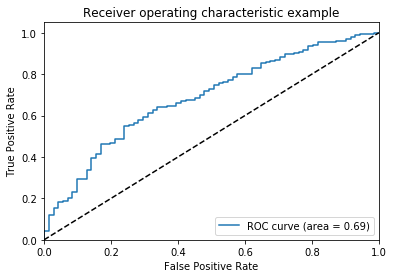

In [65]:
# Plot ROC curve
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt
%matplotlib inline

fpr = dict()
tpr = dict()
roc_auc = dict()
 
y_test = [i[1] for i in results_list]
y_score = [i[0] for i in results_list]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
 
%matplotlib inline
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

---
<a name="Interpretation of results"></a>
### Interpretation of results


Given the imbalanced distribution of labels, accuracy would be a poor choice of evaluation metric because the results would be misleading since minority classes hold minimal effect on overall accuracy. Other than being interested in whether the classification is correct or not, we might also be concerned with the true positive rate, also known as sensitivity. It measures the proportion of positives that are correctly identified as such. 
```
	|= Confusion matrix for logistic regression (2 mil instances) =
    |#############| Predicted = 1   | Predicted = 0
    |-------------+-------------------------------------------------
    |Actual = 1   | 2               |   68980
    |Actual = 0   | 22              |   1811518
    |===============================================================
```
In the confusion matrix above, the sensitivity score is almost 0%, which means that the model is poorly predicting any postives. It failed to predict 68980 clicked instances, which is over 99% of all clicked instances. This is largely due to the class imbalance problem.

Although a certain degree of hyper parameter tuning was attempted, however, due to the size of the data, it is challenging to improve on the quality on the tuning when given a time constraint. Furthermore, the cross validation parameter tuning selects the best model in each fold using the cross-validated accuracy as metric, which is not reliable in this case. Therefore, the efforts of hyper parameter tuning are fruitless here.

When trained on 2 million rows, test accuracy scores of both models were competitive, with Logistic Regression achieving 0.959, and Multilayer Perceptron achieving 0.964. Since Spark MLlib's MLP classifier does not produce probabiliies along with predicted labels, we are unable to output the Area under ROC (AUC) score. Therefore, the only way to sensibly compare the both models is to address the class imbalance first, and then compare the accuracy scores, or use different metric.

---
<a name="Address the class imbalance problem"></a>
### Address the class imbalance problem


We will proceed to illustrate the class imbalance problem with a smaller dataset with 40K instances. As seen in the pie chart below, for the train set, 96.27% of labels comprises of 'non-clicked' and only 3.73% of it is 'clicked'. This is a clear indication that we were facing a **class imbalance problem**. 

The class imbalance problem is known to heavily bias models because they focus more on the
classification of the majority sample while ignoring or misclassifying the minority sample, which causes a
classifier to perform sub-optimally.

In the following, we will implement down-sampling, or random under-sampling (RUS), to randomly eliminate samples from the majority class, with the goal of bringing the distribution of the dataset closer to the optimal distribution. Resampling involves drawing repeated samples from the original dataset. In this case, we resample the dataset to strategically bring the distribution of the data set closer to the optimal distribution by removing samples from the majority class and/or adding samples to the minority class. 


Note: For dataset with 40K instances, initial distribution of labels (classes) is  4228 instances to 303 instances

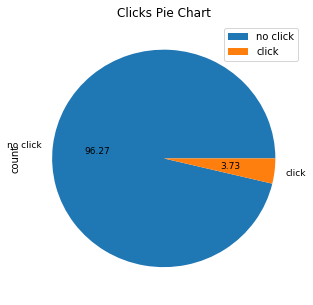

In [21]:
page_views_by_labels_pandas = traindf.groupBy('label').count().toPandas()
page_views_by_labels_pandas
%matplotlib inline
page_views_by_labels_pandas.plot.pie(y='count', figsize=(5, 5), labels=['no click', 'click',], 
                                     title='Clicks Pie Chart', autopct='%.2f', fontsize=9)

In the graph below, we can observe that the predicted probabiliies are highly skewed towards the positive cases (non-clicked). 

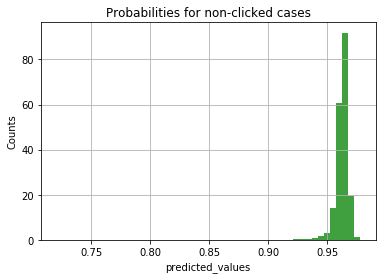

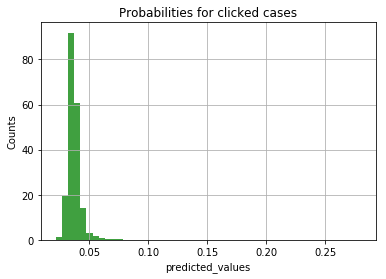

In [27]:
all_probs = finalPredictions.select("probability").collect()
pos_probs = [i[0][0] for i in all_probs]
neg_probs = [i[0][1] for i in all_probs]
 
from matplotlib import pyplot as plt
%matplotlib inline
 
# pos
plt.hist(pos_probs, 50, normed=1, facecolor='green', alpha=0.75)
plt.xlabel('predicted_values')
plt.ylabel('Counts')
plt.title('Probabilities for non-clicked cases')
plt.grid(True)
plt.show()
 
# neg
plt.hist(neg_probs, 50, normed=1, facecolor='green', alpha=0.75)
plt.xlabel('predicted_values')
plt.ylabel('Counts')
plt.title('Probabilities for clicked cases')
plt.grid(True)
plt.show()

#### Downsampling Code

In [28]:
from numpy.random import randint
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
 
RATIO_ADJUST = 2.0 ## ratio of pos to neg in the df_subsample
 
counts = df.select('binary').groupBy('binary').count().collect()
higherBound = counts[0][1]
TRESHOLD_TO_FILTER = int(RATIO_ADJUST * float(counts[1][1]) / counts[0][1] * higherBound)
 
randGen = lambda x: randint(0, higherBound) if x == "0" else -1
 
udfRandGen = udf(randGen, IntegerType())
traindf = traindf.withColumn("randIndex", udfRandGen("binary"))
df_subsample = traindf.filter(traindf['randIndex'] < TRESHOLD_TO_FILTER)
df_subsample = df_subsample.drop('randIndex')
 
print("Distribution of Pos and Neg cases of the down-sampled training data are: \n", df_subsample.groupBy("label").count().take(3))

Distribution of Pos and Neg cases of the down-sampled training data are: 
 [Row(label=0.0, count=303), Row(label=1.0, count=164)]


Non-clicked instances are dropped from 4228 instances to 303 instances.

In [29]:
t0 = time()
cvModel_logistic_resampled = cv_logistic.fit(df_subsample)
tt = time() - t0
print ("Classifier trained in {} seconds for 0.01% of dataset".format(round(tt,3)))
results_resampled = cvModel_logistic_resampled.transform(testdf)

Classifier trained in 63.939 seconds for 0.01% of dataset


In [24]:
# Logistic Regression (Regularized) BEFORE RESAMPLING
results_logistic = cvModel_logistic.transform(testdf)
evaluateModel(results_logistic, False)

Test Accuracy = 0.962905
Test F1 = 0.944708
Test Weighted Precision = 0.927186
Test Weighted Recall = 0.962905
Area under ROC curve = 0.691157252795123


In [30]:
# Logistic Regression (Regularized) AFTER RESAMPLING
evaluateModel(results_resampled, False)

Test Accuracy = 0.852142
Test F1 = 0.889908
Test Weighted Precision = 0.936969
Test Weighted Recall = 0.852142
Area under ROC curve = 0.6744514837260204


In [31]:
# BEFORE RESAMPLING
calculate_confusion_matrix(results_logistic)

|=================== Confusion matrix =======================
    |#############| Predicted = 1   | Predicted = 0
    |-------------+-------------------------------------------------
    |Actual = 1   | 0.0               |   71.0
    |Actual = 0   | 0.0               |   1843.0
    |===============================================================
    Sensitivity: 0.0
    Specificity: 1.0
    


In [32]:
# AFTER RESAMPLING
calculate_confusion_matrix(results_resampled)

|=================== Confusion matrix =======================
    |#############| Predicted = 1   | Predicted = 0
    |-------------+-------------------------------------------------
    |Actual = 1   | 21.0               |   50.0
    |Actual = 0   | 233.0               |   1610.0
    |===============================================================
    Sensitivity: 0.29577464788732394
    Specificity: 0.8735756918068367
    


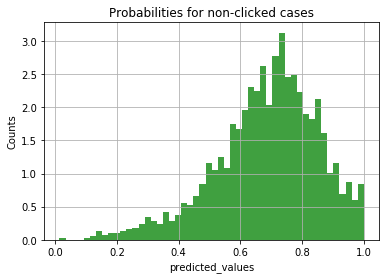

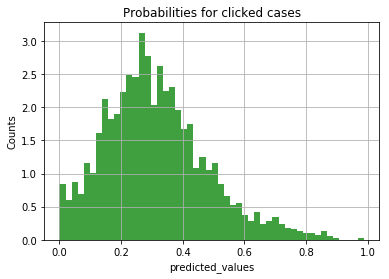

In [33]:
all_probs = results_resampled.select("probability").collect()
pos_probs = [i[0][0] for i in all_probs]
neg_probs = [i[0][1] for i in all_probs]
 
from matplotlib import pyplot as plt
%matplotlib inline
 
# pos
plt.hist(pos_probs, 50, normed=1, facecolor='green', alpha=0.75)
plt.xlabel('predicted_values')
plt.ylabel('Counts')
plt.title('Probabilities for non-clicked cases')
plt.grid(True)
plt.show()
 
# neg
plt.hist(neg_probs, 50, normed=1, facecolor='green', alpha=0.75)
plt.xlabel('predicted_values')
plt.ylabel('Counts')
plt.title('Probabilities for clicked cases')
plt.grid(True)
plt.show()

The probability distribution of predictions seems to have improved now. Although accuracy and AUC scores have dropped, the sensitivity score has improved substantially, from 0% to 21%, which means the model's predictive power on clicked instances has improved.

In this short example, the distribution of postive and negative labels in the resampled training set has a ratio of 2:1, we can continue to tweak this ratio depending on the motivation of the click prediction project. For example, if we wish to place more emphasis on the prediction of minority samples (clicked), we can allocate a smaller ratio until we reach a fairly even probability distribution of positive and negative cases. 

---
<a name="conclusion"></a>
### Conclusion


The cluster was set up with the kind support from Microsoft Azure Sponsorship, that generously provided 60 cores for the expense of this project. However, building machine learning pipelines on 1.3Tb of data requires many more cores to run efficiently and manageably. The figure below was taken from Dunner et al.[24], a paper that compared the performance of logistic regression on several machine learning libraries, on the Criteo dataset.

![logisticregcriteo](logisticregcriteo.png)

In the chart above, Rambler Digital Solutions[25] deployed a Spark 2.1.0 with total 512 cores and 2TB of memory, and trained Logistic Regression on 4.2 billion training instances, taking approximately 100 minutes. Google[26] trained a Logistic Regression model using Tensorflow, and reported using 60 workers and 29 parameter machines for the same data, clocking a very competitive test logloss score and training time. Dünner's paper on Snap ML, a new machine learning library that supports GPU accelerators in a distributed environment, trained a Logistic Regression model using 16 GPUs, clocking an impressive score. This comparison is a clear indication of the competitiveness and innovation of the development in scalable machine learning.

------

With the 40 cores set up in this project, it was only possible to train on only a subset of the dataset. We still tried to emulate the existence of big data by working on millions of instances. The results of this project are summarised in the figure below.
![logisticregcriteo](results.png)

As expected, the number of worker nodes is held accountable for the running time of the creation of pipelines and model training, because more cores allows for a higher level of parallelism. Repartitioning time was constant throughout the benchmark test because repartitioning was executed with only one node, with zero parallelism. The accuracy and AUC scores between different data sizes were rather close, which could be explained by the similarities between datasets. Since they were sampled with the same seed, on purpose, we can observe how scalability in data affects results, which, in this case, it is clear that scalability did not yield a significant improvement in results. This is especially common when the nature of data does not 'explain' enough. When sampling, it can be easy to introduce bias by selecting a dataset that misrepresents or underrepresents the real cases, which will distort the results. To improve the quality of data, datasets should always be analyzed and preprocessed with the addition of newly engineered features that improve predictive power, as well as proper means of feature selection. The process of sampling should also be done with caution, drawing samples from multiple days could be one way to decrease the bias. 

There are many takeaways for this project, large scale machine learning tasks on Spark clusters requires knowledge not just methods to optimise predicitons, but also the Spark achitecture, YARN resource manager, and Spark tuning configurations. Cluster-mode in Spark requires sufficient comprehension to take advantage of the parallelism framework, which leads to proper tuning configurations to maximize the resources of the cluster. The Spark configurations used on this project was finalzed after a long series of testing, while validating the the efficiency of the memory allocation and parallelism of jobs between worker nodes. A handful of improvements could be made to this project, such as attempting a different set of classifiers to further explore the optimization of predicted scores, deploying more cores to better handle the scalability and parallelism, as well as attempting feature engineering and feature selection. 

As Mitchell Kapor once said,
>  “Getting information off the Internet is like taking a drink from a firehose.”

The learning process of machine learning certainly feels like taking a drink from a firehose, however, it was very rewarding and worthwhile. On the whole, this opportunity has granted an interesting outlook on the domain of large scale machine learning. 



---
<a name="references"></a>
### References

[1]: Junxuan Chen, B. S.-S. (n.d.). [Deep CTR Prediction in Display Advertising]( http://wnzhang.net/share/rtb-papers/deep-ctr-display.pdfhttp://wnzhang.net/share/rtb-papers/deep-ctr-display.pdf). *ACM Multimedia Conference 2016.*
Hangzhou, China: Department of Computer Science and Engineering, Shanghai Jiao Tong University. 

[2]: [*Create an Apache Spark cluster in Azure HDInsight*.](https://docs.microsoft.com/en-gb/azure/hdinsight/spark/apache-spark-jupyter-spark-sql) (1 March, 2018). Retrieved from Microsoft.

[3]: [Deep Dive into Spark SQL Catalyst Optimizer](https://databricks.com/blog/2015/04/13/deep-dive-into-spark-sqls-catalyst-optimizer.html). (13 April, 2015) Retrieved from Databricks.

[4]: *[Project Tungsten: Bringing Apache Spark Closer to Bare Metal](https://databricks.com/blog/2015/04/28/project-tungsten-bringing-spark-closer-to-bare-metal.html)*. (28 April, 2015). Retrieved from Databricks.

[5]: *[Using Azure ML to Build Clickthrough Prediction Models](https://blogs.technet.microsoft.com/machinelearning/2015/11/03/using-azure-ml-to-build-clickthrough-prediction-models/)*. (3 November, 2015). Retrieved from Microsoft Machine Learning Blog.

[6]: Nandi, A. (2015). *Spark for Python Developers.* Packt Publishing.

[7]: Pentreath, N. (2017). *[Feature Hashing for Scalable Machine Learning](https://databricks.com/session/feature-hashing-for-scalable-machine-learning)*. Retrieved from Databricks.

[8]: Hui Zou, T. H. (2005). [Regularization and variable selection via the Elastic Net](http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.124.4696). *Journal of the Royal Statistical Society, Series B*, 301-320.

[9]: *[Logistic Regression]( https://spark.apache.org/docs/latest/ml-classification-regression.html#multilayer-perceptron-classifier)*. (n.d.). Retrieved from Apache Spark.

[10]: Fridley, J. (2010, February 22). [Tree models in R]( http://plantecology.syr.edu/fridley/bio793/cart.html ). Retrieved from Plantecology.

[11]: Marius-Constantin, V. ,.-P. (2009). *[Multilayer Perceptron and Neural Networks](http://www.wseas.us/e-library/transactions/circuits/2009/29-485.pdf) .* Romania: Faculty of Electromechanical and Environment Engineering, University of Craiova. 

[12]: *[Multilayer Perceptron Classifier](https://spark.apache.org/docs/latest/ml-classification-regression.html#multilayer-perceptron-classifier)*. (n.d.). Retrieved from Apache Spark.

[13]: Ulanov, A. (n.d.). *[A Scalable Implementation of Deep Learning on Spark](https://databricks.com/session/a-scalable-implementation-of-deep-learning-on-spark)*. Retrieved from Databricks.

[14]: Longadge, R., Dongre, S. S., & Malik, L. (2013, February). Class Imbalance Problem in Data Mining: Review. International Journal of Computer Science and Network 

[15]: Malouf, Robert (2002). [*A comparison of algorithms for maximum entropy parameter estimation*](https://web.archive.org/web/20131101205929/http://acl.ldc.upenn.edu/W/W02/W02-2018.pdf). Proc. Sixth Conf. on Natural Language Learning (CoNLL). pp. 49–55. Archived from [the original](http://acl.ldc.upenn.edu/W/W02/W02-2018.pdf) on 2013-11-01.

[16]: Wang, W. (9 June, 2016). *[PySpark tutorial – a case study using Random Forest on unbalanced dataset](https://weiminwang.blog/2016/06/09/pyspark-tutorial-building-a-random-forest-binary-classifier-on-unbalanced-dataset/)*. Retrieved from Weimin Wang Blog.

[17]: Milan Vojnovic, C. Y. (1 March, 2018). *[Logistic Regression Pipeline](https://github.com/lse-st446/lectures/blob/master/week07/class/logistic_regression_pipeline.ipynb)*. Retrieved from Github.

[18]: Nandi, A. (2015). *Spark for Python Developers.* Packt Publishing.

[19]: Karau, H. (2016). *High Performance Spark: Best Practices for Scaling and Optimizing Apache Spark.* O′Reilly.

[20]: Drabas, T. (2017). *Learning PySpark.* Packt Publishing.

[21]: [*How-to: Tune Your Apache Spark Jobs (Part 2)*.](https://blog.cloudera.com/blog/2015/03/how-to-tune-your-apache-spark-jobs-part-2/) (30 March, 2018). Retrieved from Databricks.

[22]: Gurbuzbalaban, M., Ozdaglar, A., Parrilo, P. A., & Vanli, N. (2017). [*When Cyclic Coordinate Descent Outperforms Randomized Coordinate Descent*.](https://papers.nips.cc/paper/7275-when-cyclic-coordinate-descent-outperforms-randomized-coordinate-descent.pdf) In Advances in Neural Information Processing Systems (pp. 7002-7010).

[23]: Friedman, J., Hastie, T., & Tibshirani, R. (2010). Regularization paths for generalized linear models via coordinate descent. Journal of statistical software, 33(1), 1.

[24]: Dünner, C., Parnell, T., Sarigiannis, D., Ioannou, N., & Pozidis, H. (2018). [*Snap Machine Learning*](https://arxiv.org/pdf/1803.06333.pdf). arXiv preprint arXiv:1803.06333.

[25]:  Rambler Digital Solutions. 2017. [*criteo-1tb-benchmark*](https://github.com/rambler-digital-solutions/criteo-1tb-benchmark). (2017). 

[26]: Andreas Sterbenz. 2017. [*Using Google Cloud Machine Learning to predict clicks at scale.*](https://cloud.google.com/blog/big-data/2017/02/using-google-cloud-machine-learning-to-predict-clicks-at-scale) Retrieved from Google.

[27]: Umbertogriffo (2018). [*Apache Spark - Best Practices and Tuning*](https://legacy.gitbook.com/book/umbertogriffo/apache-spark-best-practices-and-tuning/details). Retrieved from Gitbook.